In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import random
random.seed(13847942484)
import survivalstan
import numpy as np
import pandas as pd
from stancache import stancache
from matplotlib import pyplot as plt

INFO:stancache.seed:Setting seed to 1245502385


In [2]:
print(survivalstan.models.pem_survival_model_timevarying)

/*  Variable naming:
 // dimensions
 N          = total number of observations (length of data)
 S          = number of sample ids
 T          = max timepoint (number of timepoint ids)
 M          = number of covariates
 
 // data
 s          = sample id for each obs
 t          = timepoint id for each obs
 event      = integer indicating if there was an event at time t for sample s
 x          = matrix of real-valued covariates at time t for sample n [N, X]
 obs_t      = observed end time for interval for timepoint for that obs
 
*/
// Jacqueline Buros Novik <jackinovik@gmail.com>

functions {
  matrix spline(vector x, int N, int H, vector xi, int P) {
    matrix[N, H + P] b_x;         // expanded predictors
    for (n in 1:N) {
        for (p in 1:P) {
            b_x[n,p] <- pow(x[n],p-1);  // x[n]^(p-1)
        }
        for (h in 1:H)
          b_x[n, h + P] <- fmax(0, pow(x[n] - xi[h],P-1)); 
    }
    return b_x;
  }
}
data {
  // dimensions
  int<lower=1> N;
  int<lower=1> S;
 

In [3]:
d = stancache.cached(
    survivalstan.sim.sim_data_exp_correlated,
    N=100,
    censor_time=20,
    rate_form='1 + sex',
    rate_coefs=[-3, 0.5],
)
d['age_centered'] = d['age'] - d['age'].mean()
d.head()

INFO:stancache.stancache:sim_data_exp_correlated: cache_filename set to sim_data_exp_correlated.cached.N_100.censor_time_20.rate_coefs_54462717316.rate_form_1 + sex.pkl
INFO:stancache.stancache:sim_data_exp_correlated: Loading result from cache


,sex,age,rate,true_t,t,event,index,age_centered
0,male,54,0.082085,1.013855,1.013855,True,0,-1.12
1,male,39,0.082085,4.890597,4.890597,True,1,-16.12
2,female,45,0.049787,4.093404,4.093404,True,2,-10.12
3,female,43,0.049787,7.036226,7.036226,True,3,-12.12
4,female,57,0.049787,5.712299,5.712299,True,4,1.88


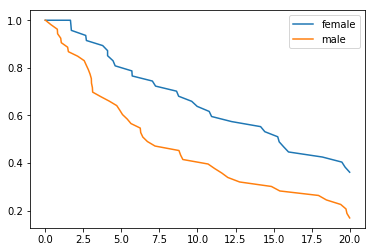

In [4]:
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='female'], event_col='event', time_col='t', label='female')
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='male'], event_col='event', time_col='t', label='male')
plt.legend()

In [5]:
dlong = stancache.cached(
    survivalstan.prep_data_long_surv,
    df=d, event_col='event', time_col='t'
)
dlong.sort_values(['index', 'end_time'], inplace=True)

INFO:stancache.stancache:prep_data_long_surv: cache_filename set to prep_data_long_surv.cached.df_14209590808.event_col_event.time_col_t.pkl
INFO:stancache.stancache:prep_data_long_surv: Loading result from cache


In [6]:
dlong.head()

,sex,age,rate,true_t,t,event,index,age_centered,end_time,end_failure
73,male,54,0.082085,1.013855,1.013855,True,0,-1.12,0.009787,False
65,male,54,0.082085,1.013855,1.013855,True,0,-1.12,0.377535,False
72,male,54,0.082085,1.013855,1.013855,True,0,-1.12,0.791192,False
58,male,54,0.082085,1.013855,1.013855,True,0,-1.12,0.808987,False
0,male,54,0.082085,1.013855,1.013855,True,0,-1.12,1.013855,True


In [7]:
testfit = survivalstan.fit_stan_survival_model(
    model_cohort = 'test model',
    model_code = survivalstan.models.pem_survival_model_timevarying,
    df = dlong,
    sample_col = 'index',
    timepoint_end_col = 'end_time',
    event_col = 'end_failure',
    formula = '~ age_centered + sex',
    iter = 10000,
    chains = 4,
    seed = 9001,
    FIT_FUN = stancache.cached_stan_fit,
    )

INFO:stancache.stancache:Step 1: Get compiled model code, possibly from cache
INFO:stancache.stancache:StanModel: cache_filename set to anon_model.cython_0_29_2.model_code_10216236489136838232.pystan_2_18_1_0.stanmodel.pkl
INFO:stancache.stancache:StanModel: Loading result from cache
INFO:stancache.stancache:Step 2: Get posterior draws from model, possibly from cache
INFO:stancache.stancache:sampling: cache_filename set to anon_model.cython_0_29_2.model_code_10216236489136838232.pystan_2_18_1_0.stanfit.chains_4.data_98562805320.iter_10000.seed_9001.pkl
INFO:stancache.stancache:sampling: Loading result from cache


## superficial check of convergence

In [8]:
survivalstan.utils.print_stan_summary([testfit], pars='lp__')

            mean    se_mean          sd       2.5%         50%      97.5%      Rhat
lp__  438.367242  33.037071  136.999711  60.442022  454.291446  665.11812  1.245577


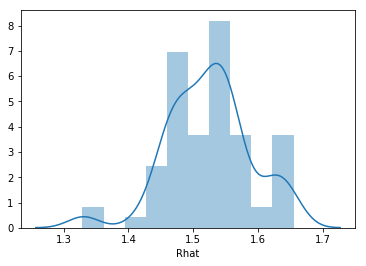

In [9]:
survivalstan.utils.plot_stan_summary([testfit], pars='log_baseline')

## summarize coefficient estimates

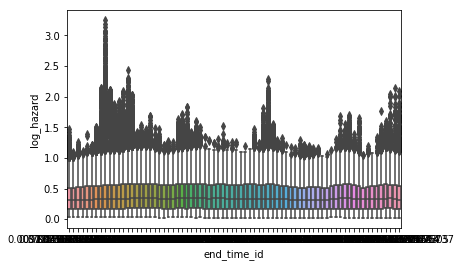

In [10]:
survivalstan.utils.plot_coefs([testfit], element='baseline')

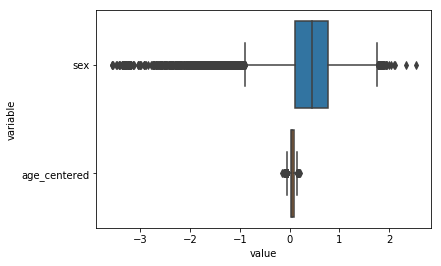

In [11]:
survivalstan.utils.plot_coefs([testfit])

## posterior-predictive checks

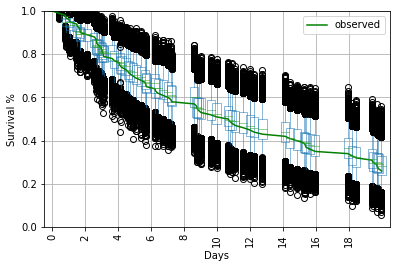

In [12]:
survivalstan.utils.plot_pp_survival([testfit], fill=False)
survivalstan.utils.plot_observed_survival(df=d, event_col='event', time_col='t', color='green', label='observed')
plt.legend()

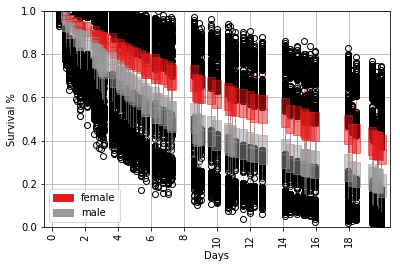

In [13]:
survivalstan.utils.plot_pp_survival([testfit], by='sex')

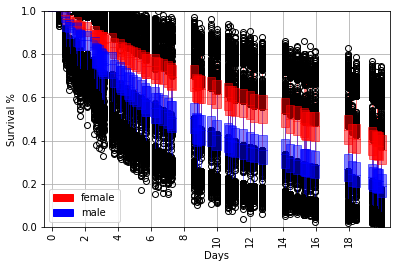

In [14]:
survivalstan.utils.plot_pp_survival([testfit], by='sex', pal=['red', 'blue'])

## summarize time-varying effect of sex on survival

Standard behavior is to plot estimated betas at each timepoint, for each coefficient in the model.

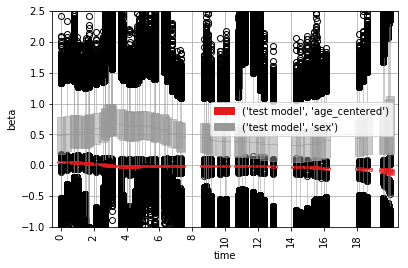

In [15]:
survivalstan.utils.plot_coefs([testfit], element='beta_time', ylim=[-1, 2.5])

## accessing lower-level functions for plotting effects over time

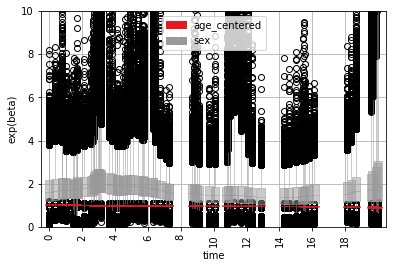

In [16]:
survivalstan.utils.plot_time_betas(models=[testfit], by=['coef'], y='exp(beta)', ylim=[0, 10])

Alternatively, you can extract the beta-estimates for each timepoint & plot them yourself.

In [17]:
testfit['time_beta'] = survivalstan.utils.extract_time_betas([testfit])
testfit['time_beta'].head()

,iter,_timepoint_id,beta,coef,end_time,exp(beta),model_cohort
0,0,1,1.303891,sex,0.009787,3.683601,test model
1,1,1,0.349997,sex,0.009787,1.419063,test model
2,2,1,0.348042,sex,0.009787,1.416292,test model
3,3,1,0.200147,sex,0.009787,1.221583,test model
4,4,1,0.189725,sex,0.009787,1.208917,test model


You can also extract and/or plot data for single coefficients of interest at a time.

In [18]:
first_beta = survivalstan.utils.extract_time_betas([testfit], coefs=['sex[T.male]'])
first_beta.head()

ValueError: No objects to concatenate

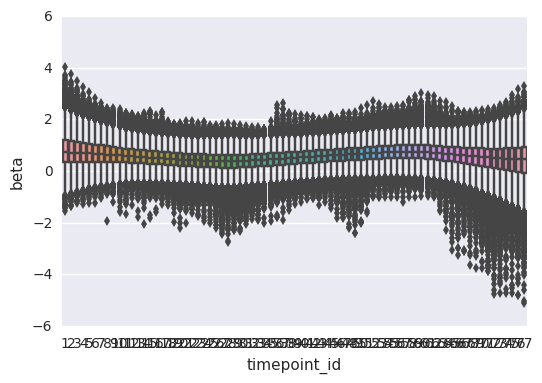

In [30]:
import seaborn as sns
sns.boxplot(data=first_beta, x='timepoint_id', y='beta')

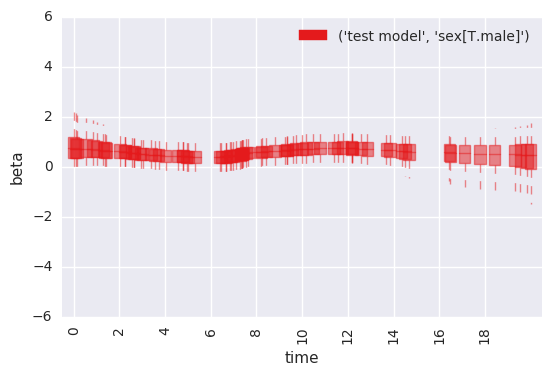

In [32]:
survivalstan.utils.plot_time_betas(models=[testfit], y='beta', x='end_time', coefs=['sex[T.male]'])

Note that this same plot can be produced by passing data to `plot_time_betas` directly.

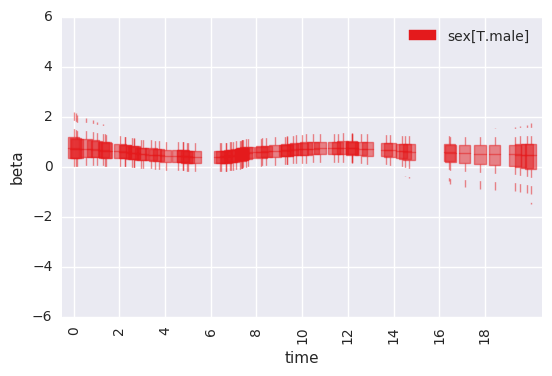

In [33]:
survivalstan.utils.plot_time_betas(df=first_beta, by=['coef'], y='beta', x='end_time')